In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset from UCI repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
try:
    data = pd.read_csv(url, header=None, na_values='?')  # Load dataset, treating '?' as NaN
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Assign column names (from UCI dataset description)
column_names = [
    "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10",
    "A11", "A12", "A13", "A14", "A15", "target"
]
data.columns = column_names


Dataset loaded successfully!


In [4]:
# Step 1: Data Exploration
print("First 5 rows of the dataset:")
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nStatistical Summary:")
print(data.describe())

First 5 rows of the dataset:
  A1     A2     A3 A4 A5 A6 A7    A8 A9 A10  A11 A12 A13    A14  A15 target
0  b  30.83  0.000  u  g  w  v  1.25  t   t    1   f   g  202.0    0      +
1  a  58.67  4.460  u  g  q  h  3.04  t   t    6   f   g   43.0  560      +
2  a  24.50  0.500  u  g  q  h  1.50  t   f    0   f   g  280.0  824      +
3  b  27.83  1.540  u  g  w  v  3.75  t   t    5   t   g  100.0    3      +
4  b  20.17  5.625  u  g  w  v  1.71  t   f    0   f   s  120.0    0      +

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      678 non-null    object 
 1   A2      678 non-null    float64
 2   A3      690 non-null    float64
 3   A4      684 non-null    object 
 4   A5      684 non-null    object 
 5   A6      681 non-null    object 
 6   A7      681 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 n

In [6]:
# Step 2: Data Preprocessing
# Handle missing values
# Handle missing values
data.fillna(data.median(numeric_only=True), inplace=True)  # Fill numeric NaN values with column medians
data.ffill(inplace=True)  # Forward-fill missing values for categorical columns

# Encode categorical data
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop('target', axis=1))
data_scaled = pd.DataFrame(scaled_features, columns=data.columns[:-1])

# Separate features and target
X = data_scaled
y = data['target'].replace({'+': 1, '-': 0})  # Convert target to binary: '+' → 1, '-' → 0

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [7]:
# Step 3: Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)



Random Forest Performance:
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        76
           1       0.92      0.92      0.92        78

    accuracy                           0.92       154
   macro avg       0.92      0.92      0.92       154
weighted avg       0.92      0.92      0.92       154

Confusion Matrix:


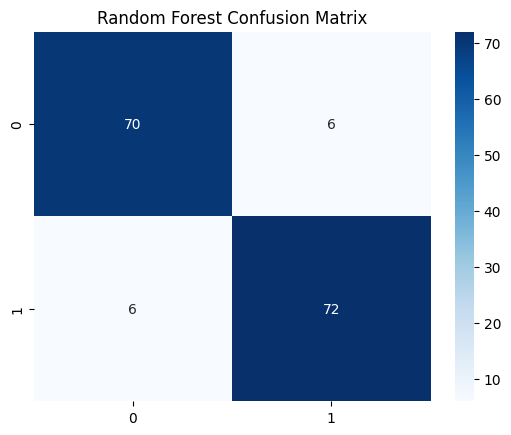


Gradient Boosting Performance:
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        76
           1       0.92      0.91      0.92        78

    accuracy                           0.92       154
   macro avg       0.92      0.92      0.92       154
weighted avg       0.92      0.92      0.92       154

Confusion Matrix:


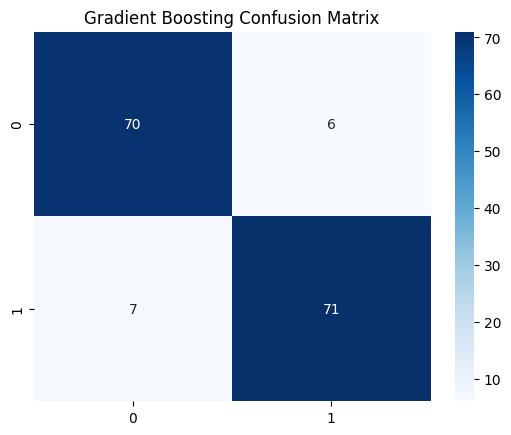

In [8]:
# Step 4: Model Training and Evaluation
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

In [9]:
# Step 5: Fairness Analysis (Optional)
# Check for bias by analyzing predictions across different demographic groups
# Example: A1 (Gender) as a demographic-sensitive attribute
demographic_column = 'A1'
for group in data[demographic_column].unique():
    group_indices = data[demographic_column] == group
    group_X = X.iloc[group_indices.index]
    group_y = y[group_indices.index]
    group_y_pred = models["Random Forest"].predict(group_X)
    print(f"Performance for group {group}:")
    print(f"Accuracy: {accuracy_score(group_y, group_y_pred):.2f}")

Performance for group 1:
Accuracy: 0.98
Performance for group 0:
Accuracy: 0.98


In [13]:
def predict_credit_approval(input_data, model):
    # Convert the input into a DataFrame with the same feature names
    input_df = pd.DataFrame([input_data], columns=data.columns[:-1])  # Exclude the 'target' column
    
    # Scale the input while keeping it as a DataFrame
    input_data_scaled = pd.DataFrame(scaler.transform(input_df), columns=data.columns[:-1])
    
    # Predict using the model
    prediction = model.predict(input_data_scaled)
    return "Approved" if prediction[0] == 1 else "Rejected"

# Example usage of the prediction function
sample_input = [1, 30, 20000, 1, 2, 0, 3, 1500, 1, 0, 2, 1, 0, 25, 1]  # Example applicant details
print("Prediction:", predict_credit_approval(sample_input, models["Random Forest"]))


Prediction: Rejected


In [14]:
sample_input = [0, 45, 50000, 1, 3, 1, 2, 2500, 1, 1, 1, 0, 0, 30, 1]  # Higher income, stable profile
print("Prediction:", predict_credit_approval(sample_input, models["Random Forest"]))


Prediction: Rejected


In [26]:
sample_input_row3 = X_train.iloc[3].tolist()  # Get the 4th row (index 3) from training data
print("Prediction:", predict_credit_approval(sample_input_row3, models["Random Forest"]))

Prediction: Approved


In [27]:
sample_input_row4 = X_train.iloc[4].tolist()  # Get the 5th row (index 4) from training data
print("Prediction:", predict_credit_approval(sample_input_row4, models["Random Forest"]))

Prediction: Approved
